## Data Balanced

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# Función para limpiar texto
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in set(stopwords.words('english')) and len(word) > 2]
    return ' '.join(text)

# Cargar datos
df = pd.read_csv("../data/merged_reviews.csv")

# Filtrar puntaje 3 y convertir a clasificación binaria
df_binary = df[df["review/score"] != 3].copy()
df_binary["label"] = df_binary["review/score"].apply(lambda x: 1 if x > 3 else 0)

# Verificar desbalance
print("Distribución original:")
print(df_binary["label"].value_counts())

# Submuestreo para balancear
positivos = df_binary[df_binary["label"] == 1].sample(n=df_binary["label"].value_counts()[0], random_state=42)
negativos = df_binary[df_binary["label"] == 0]
balanced_df = pd.concat([positivos, negativos]).sample(frac=1, random_state=42).reset_index(drop=True)

# Limpieza de texto
balanced_df["clean_summary"] = balanced_df["review/summary"].apply(clean_text)

# Verificar resultado
print("\nDistribución balanceada:")
print(balanced_df["label"].value_counts())
print("\nEjemplo de resumen limpio:")
print(balanced_df[["review/summary", "clean_summary"]].head())

# Guardar dataset balanceado
balanced_df.to_csv("../data/balanced_reviews.csv", index=False)
print("\n✅ Dataset balanceado guardado como 'balanced_reviews.csv'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Distribución original:
label
1    2392645
0     352683
Name: count, dtype: int64

Distribución balanceada:
label
1    352683
0    352683
Name: count, dtype: int64

Ejemplo de resumen limpio:
                                      review/summary  \
0                           Book for nonbelievers...   
1  Not so great in the first place, it is now wil...   
2                                    Did you know...   
3                                             Great!   
4                       I don't believe she wrote it   

                       clean_summary  
0                   book nonbeliever  
1  great first place wildly outdated  
2                               know  
3                              great  
4                      believe wrote  

✅ Dataset balanceado guardado como 'balanced_reviews.csv'


## Train

## Modelos compatibles con sparse

In [6]:
import pandas as pd

# Cargar dataset balanceado
df = pd.read_csv("../data/balanced_reviews.csv")
print(df.head(10))


                                      review/summary  review/score  label  \
0                           Book for nonbelievers...           5.0      1   
1  Not so great in the first place, it is now wil...           2.0      0   
2                                    Did you know...           5.0      1   
3                                             Great!           5.0      1   
4                       I don't believe she wrote it           1.0      0   
5                          What Happened Angie Sage?           2.0      0   
6  Interesting idea and well written, but conscie...           1.0      0   
7                                 purely for fiction           2.0      0   
8                          Entertainment at its best           5.0      1   
9               Classic brilliance, plain and simple           5.0      1   

                                       clean_summary  
0                                   book nonbeliever  
1                  great first place wildl

## LLR & SVM

2025-07-09 12:23:01 | INFO | 📥 Loading dataset...
2025-07-09 12:23:02 | INFO | ✅ Dataset size: 700,309 samples
2025-07-09 12:23:02 | INFO | 🔍 Preparing corpus...
2025-07-09 12:29:46 | INFO | 🧹 Vectorizing with TF-IDF...
2025-07-09 12:29:50 | INFO | ✅ Train samples: 560,247, Test samples: 140,062
2025-07-09 12:29:50 | INFO | 🔧 Setting up models...
2025-07-09 12:29:50 | INFO | 🚀 Training Logistic Regression...
2025-07-09 12:29:53 | INFO | ✅ Logistic Regression trained successfully!
2025-07-09 12:29:53 | INFO | 🚀 Training Linear SVM...
2025-07-09 12:30:16 | INFO | ✅ Linear SVM trained successfully!
2025-07-09 12:30:17 | INFO | 
=== Model Results ===
                 Model  Accuracy        F1  Precision    Recall
1           Linear SVM  0.789629  0.789566   0.789828  0.789629
0  Logistic Regression  0.789579  0.789531   0.789716  0.789579
2025-07-09 12:30:17 | INFO | 🏆 Best Model: Linear SVM
2025-07-09 12:30:17 | INFO | 
=== Classification Report ===
              precision    recall  f1-s

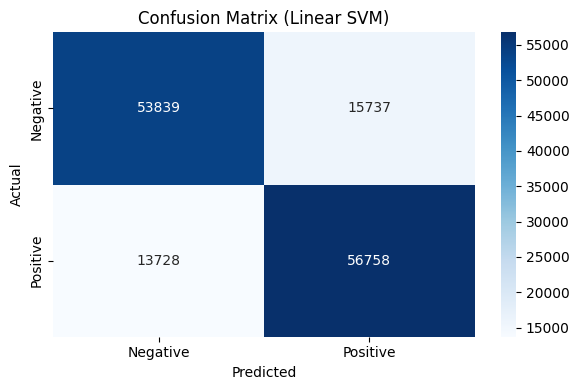

In [19]:
import logging
import pandas as pd
import seaborn as sns
import os
import sys

from sklearn.calibration import CalibratedClassifierCV, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from matplotlib import pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from machine_learning.scripts.data_prep import prepare_corpus
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# =============================
# Setup logging
# =============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


# =============================
# Load data
# =============================
logger.info("📥 Loading dataset...")
dataset = pd.read_csv("../data/balanced_reviews.csv")
dataset = dataset.dropna(subset=["clean_summary"])
dataset["clean_summary"] = dataset["clean_summary"].astype(str)
dataset = dataset.reset_index(drop=True)
logger.info(f"✅ Dataset size: {len(dataset):,} samples")

# =============================
# Prepare corpus
# =============================
logger.info("🔍 Preparing corpus...")
corpus = prepare_corpus(dataset, "clean_summary")
labels = dataset["label"].values[:len(corpus)]

# =============================
# Vectorize
# =============================
logger.info("🧹 Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(corpus)
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logger.info(f"✅ Train samples: {X_train.shape[0]:,}, Test samples: {X_test.shape[0]:,}")

# =============================
# Define models
# =============================
logger.info("🔧 Setting up models...")
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', max_iter=1000
    ),
    "Linear SVM": CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', max_iter=1000)
    )
}

# =============================
# Train & evaluate
# =============================
results = []
trained_models = {}

try:
    for name, model in models.items():
        logger.info(f"🚀 Training {name}...")
        model.fit(X_train, y_train)
        logger.info(f"✅ {name} trained successfully!")

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1": f1,
            "Precision": precision,
            "Recall": recall
        })
        trained_models[name] = model

except KeyboardInterrupt:
    logger.warning("🛑 Training interrupted by user!")
    exit()

# =============================
# Results & Save best
# =============================
df_results = pd.DataFrame(results).sort_values(by='F1', ascending=False)
logger.info("\n=== Model Results ===\n%s", df_results)

best_model_name = df_results.iloc[0]['Model']
best_model = trained_models[best_model_name]
logger.info(f"🏆 Best Model: {best_model_name}")


# =============================
# CM & Classification Report
# =============================

y_test_pred = best_model.predict(X_test)
logger.info("\n=== Classification Report ===\n%s",
            classification_report(y_test, y_test_pred, target_names=["Negative", "Positive"], zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
logger.info(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix ({best_model_name})")
plt.tight_layout()
plt.show()

In [15]:
print(dataset['label'].value_counts())
print(dataset['label'].value_counts(normalize=True))  # proporciones

label
1    351498
0    348811
Name: count, dtype: int64
label
1    0.501918
0    0.498082
Name: proportion, dtype: float64


In [ ]:
print("Cantidad total de muestras:", len(dataset))

Cantidad total de muestras: 700309


2025-07-09 12:01:37 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-09 12:01:38 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


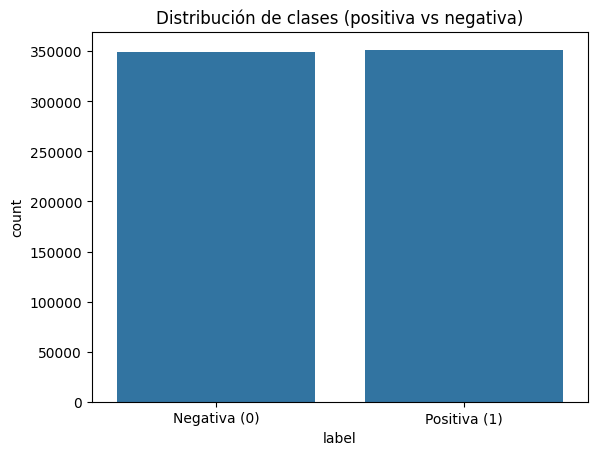

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=dataset)
plt.title("Distribución de clases (positiva vs negativa)")
plt.xticks([0,1], ["Negativa (0)", "Positiva (1)"])
plt.show()

In [28]:
print("Nulos por columna:")
print(dataset.isnull().sum())

print("Duplicados:", dataset.duplicated().sum())


Nulos por columna:
review/summary    0
review/score      0
label             0
clean_summary     0
dtype: int64
Duplicados: 227027


## Decision Tree & Random Forest

2025-07-09 12:03:42 | INFO | 📥 Loading dataset...
2025-07-09 12:03:43 | INFO | ✅ Dataset size: 700,309 samples
2025-07-09 12:03:43 | INFO | 🔍 Preparing corpus...
2025-07-09 12:10:41 | INFO | 🧹 Vectorizing with TF-IDF...
2025-07-09 12:10:45 | INFO | ✅ Train samples: 560,247, Test samples: 140,062
2025-07-09 12:10:45 | INFO | 🔧 Setting up models...
2025-07-09 12:10:45 | INFO | 🚀 Training Logistic Regression...
2025-07-09 12:10:48 | INFO | ✅ Logistic Regression trained successfully!
2025-07-09 12:10:48 | INFO | 🚀 Training Linear SVM...
2025-07-09 12:11:10 | INFO | ✅ Linear SVM trained successfully!
2025-07-09 12:11:10 | INFO | 🚀 Training Decision Tree...
2025-07-09 12:11:15 | INFO | ✅ Decision Tree trained successfully!
2025-07-09 12:11:15 | INFO | 🚀 Training Random Forest...
2025-07-09 12:11:28 | INFO | ✅ Random Forest trained successfully!
2025-07-09 12:11:29 | INFO | 
=== Model Results ===
              Model  Accuracy       F1  Precision   Recall
         Linear SVM  0.789629 0.789566

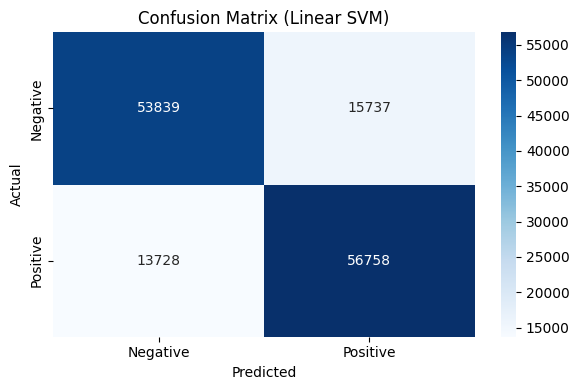

In [ ]:
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))  # Añade raíz del proyecto

from machine_learning.scripts.data_prep import prepare_corpus
from sklearn.metrics import classification_report, confusion_matrix


# =============================
# Setup logging
# =============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


# =============================
# Load data
# =============================
logger.info("📥 Loading dataset...")
dataset = pd.read_csv("../data/balanced_reviews.csv")
dataset = dataset.dropna(subset=["clean_summary"])
dataset["clean_summary"] = dataset["clean_summary"].astype(str)
dataset = dataset.reset_index(drop=True)
logger.info(f"✅ Dataset size: {len(dataset):,} samples")

# =============================
# Prepare corpus
# =============================
logger.info("🔍 Preparing corpus...")
corpus = prepare_corpus(dataset, "clean_summary")
labels = dataset["label"].values[:len(corpus)]

# =============================
# Vectorize
# =============================
logger.info("🧹 Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(corpus)
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logger.info(f"✅ Train samples: {X_train.shape[0]:,}, Test samples: {X_test.shape[0]:,}")

# =============================
# Define models
# =============================
logger.info("🔧 Setting up models...")
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', max_iter=1000
    ),
    "Linear SVM": CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', max_iter=1000)
    ),
    "Decision Tree": DecisionTreeClassifier(
        class_weight='balanced', max_depth=10, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced', n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    )
}

# =============================
# Train & evaluate
# =============================
results = []
trained_models = {}

try:
    for name, model in models.items():
        logger.info(f"🚀 Training {name}...")
        model.fit(X_train, y_train)
        logger.info(f"✅ {name} trained successfully!")

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1": f1,
            "Precision": precision,
            "Recall": recall
        })
        trained_models[name] = model

except KeyboardInterrupt:
    logger.warning("🛑 Training interrupted by user!")
    exit()

# =============================
# Results & Save best
# =============================
df_results = pd.DataFrame(results).sort_values(by='F1', ascending=False)
logger.info("\n=== Model Results ===\n%s", df_results.to_string(index=False))

best_model_name = df_results.iloc[0]['Model']
best_model = trained_models[best_model_name]
logger.info(f"🏆 Best Model: {best_model_name}")


# =============================
# CM & Classification Report
# =============================

y_test_pred = best_model.predict(X_test)
logger.info("\n=== Classification Report ===\n%s",
            classification_report(y_test, y_test_pred, target_names=["Negative", "Positive"], zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
logger.info(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix ({best_model_name})")
plt.tight_layout()
plt.show()

# =============================
# 📊 Plot F1-Scores comparison
# =============================
plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x='F1', y='Model', palette='viridis')

plt.title('Comparación de F1-Scores por Modelo', fontsize=14)
plt.xlabel('F1-Score')
plt.ylabel('Modelo')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()